# Airbnb-AI
A ml-project to predict rent of an airbnb flat in Barcelona
Nils Liebrand, Till Malte Friedrich, Than Tran

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')
import requests
import unicodedata
from PIL import Image
from io import BytesIO
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import zipfile
import ast
import matplotlib.pyplot as plt
import geopandas as gpd
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/calendar.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._reviews.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._listings_2.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/neighbourhoods.geojson
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._neighbourhoods.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings_2.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._listings.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/reviews.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._neighbourhoods.geojson
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._calendar.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/neighbourhoods.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/._reviews_2.csv
/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/reviews_2.csv


In [2]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


# Extracing the data

In [3]:
listing_data = pd.read_csv('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings.csv', encoding="latin1")
listing_details_data = pd.read_csv('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/listings_2.csv' , encoding="latin1")
review_data = pd.read_csv('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/reviews.csv' , encoding="latin1")
geo_data = gpd.read_file('/kaggle/input/barcelona-airbnb/barcelona_airbnbdata/neighbourhoods.geojson')


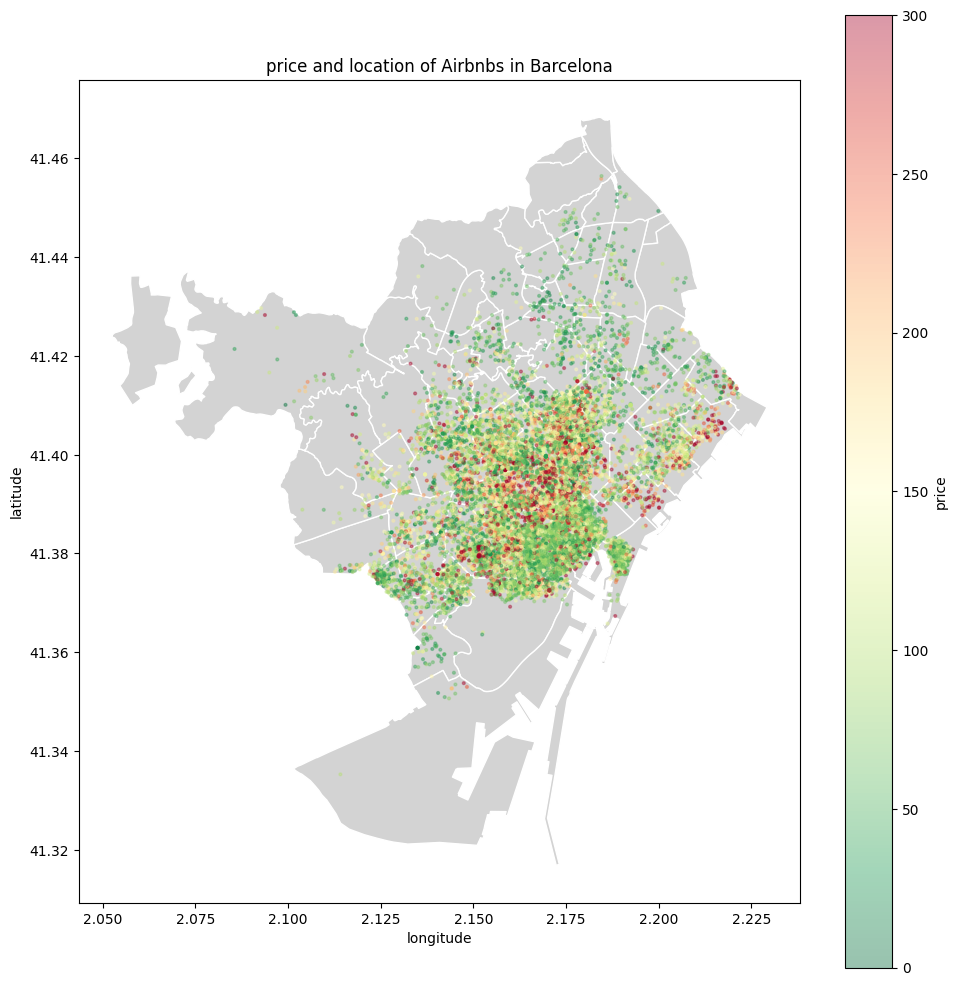

In [4]:
#visualizing the data
def plotData(information = 'price', vmax = 300):
    #longitudes = listing_data["longitude"]
    #latitudes = listing_data["latitude"]
    data = listing_data[information].astype(float)

    mask = data != 0
    filtered_data = data[mask]
    filtered_lons = listing_data["longitude"][mask]
    filtered_lats = listing_data["latitude"][mask]
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    geo_data.plot(ax=ax, color='lightgrey', edgecolor='white')
    
    sc = ax.scatter(
        filtered_lons,
        filtered_lats,
        c=filtered_data,
        cmap='RdYlGn_r',
        s=4,
        vmin=0,
        vmax=vmax,
        alpha=0.4
    )
    
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(information)
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    
    ax.set_title(information + " and location of Airbnbs in Barcelona")
    plt.tight_layout()
    plt.show()

plotData()

## Processing the data

In [5]:
#listings
#remove unnecessary data
columns_to_remove = ['listing_url', 'scrape_id', 'host_url', 'host_id', 'host_thumbnail_url' ,  'last_scraped', 'source', 'bathrooms_text', 'calendar_updated', 'calendar_last_scraped']
listing_details_data = listing_details_data.drop(columns=columns_to_remove)
listing_data = listing_data.drop(columns=['host_id'])

In [6]:
#find dublicates
column_names = listing_data.columns.tolist()
for column in column_names:
    
    if column in listing_details_data.columns.tolist():
        listing_details_data = listing_details_data.drop(columns = column)
        
listing_data = pd.concat([listing_data, listing_details_data], axis=1)

In [7]:

        

#reviews
#remove unnecessary data
columns_to_remove = ['reviewer_id', "id"]
review_data = review_data.drop(columns = columns_to_remove)

print(listing_data[:5])
print(review_data[:5])

#TODO - replace nan and missing values.
#TODO - text to numerical data
#TODO - One hot encoding for host verification types
#TODO - Download images from image links and add to barcelon-airbnb dataset. (No merging needed pytorch dataset can handle external image loading)


      id                                               name       host_name  \
0  18674    Huge flat for 8 people close to Sagrada Familia   Mireia  Maria   
1  23197  Forum CCIB DeLuxe, Spacious, Large Balcony, relax  Etain (Marnie)   
2  32711                  Sagrada Familia area - CÃ²rsega 1            Nick   
3  34241   Stylish Top Floor Apartment - Ramblas Plaza Real          Andres   
4  34981               VIDRE HOME PLAZA REAL on LAS RAMBLAS          Andres   

  neighbourhood_group                        neighbourhood   latitude  \
0            Eixample                  la Sagrada FamÃ­lia  41.405560   
1         Sant MartÃ­               el BesÃ²s i el Maresme  41.412432   
2             GrÃ cia  el Camp d'en Grassot i GrÃ cia Nova  41.405660   
3        Ciutat Vella                      el Barri GÃ²tic  41.380620   
4        Ciutat Vella                      el Barri GÃ²tic  41.379780   

   longitude        room_type  price  minimum_nights  ...  \
0    2.17262  Entire home

## Handle Nan data

In [8]:
#Nan handling
for column in listing_data.columns.tolist():
    isString = False
    isNumerical = False
    isCategorial = False
    for x in listing_data[column]:
        if type(x) == str:
            isString = True
            print(f"replaced_str: {column}")
            break
        elif type(x) == float or type(x) == int:
            if x > 1:
                isNumerical = True
                print(f"replaced_numerical: {column}")
            break
        elif type(x) == float or type(x) == int:
            if x in [0,1]:
                isCategorial = True
                print(f"replaced_categorial: {column}")
    
    if isString:
        listing_data[column].replace('nan', '')
        
    if isNumerical:
        listing_data[column].replace('nan', 0)

    if isCategorial:
        listing_data[column].replace('nan', 0)
        
        
                
            

replaced_numerical: id
replaced_str: name
replaced_str: host_name
replaced_str: neighbourhood_group
replaced_str: neighbourhood
replaced_numerical: latitude
replaced_numerical: longitude
replaced_str: room_type
replaced_numerical: price
replaced_numerical: number_of_reviews
replaced_str: last_review
replaced_numerical: calculated_host_listings_count
replaced_numerical: availability_365
replaced_numerical: number_of_reviews_ltm
replaced_str: license
replaced_str: description
replaced_str: neighborhood_overview
replaced_str: picture_url
replaced_str: host_since
replaced_str: host_location
replaced_str: host_about
replaced_str: host_response_time
replaced_str: host_response_rate
replaced_str: host_acceptance_rate
replaced_str: host_is_superhost
replaced_str: host_picture_url
replaced_str: host_neighbourhood
replaced_numerical: host_listings_count
replaced_numerical: host_total_listings_count
replaced_str: host_verifications
replaced_str: host_has_profile_pic
replaced_str: host_identity_ve

## Handling categorial and image data

In [9]:



#expanding listing data amenities list into inidividual rows
cat_dict = {}
for listing in listing_data["amenities"]:
    listing = listing.replace('[]"', '').replace("[", "").replace("]", "").replace('"', '')
    listing = listing.split(',')
    for x in listing:
        x = x.strip().lower()
        if x in cat_dict:
            cat_dict[x] += 1
        else:
            cat_dict[x] = 1


#take 100 most frequent categories
top_amenities = sorted(cat_dict.items(), key=lambda x: x[1], reverse=True)[:100]
relevant_categories = [cat for cat, _ in top_amenities]
    

def encode_amenities(amenity_str):
    amenities = amenity_str.replace('[]"', '').replace("[", "").replace("]", "").replace('"', '')
    amenity_list = [a.strip().lower() for a in amenities.split(',')]
    row = {}
    for category in relevant_categories:
        row[category] = int(any(category in a for a in amenity_list))
    return row
    

encoded_df = listing_data["amenities"].apply(encode_amenities).apply(pd.Series)
encoded_df.columns = [col.replace(" ", "_") for col in encoded_df.columns]
listing_data = pd.concat([listing_data, encoded_df], axis=1)
listing_data = listing_data.drop(columns='amenities')

print(listing_data[:5])


      id                                               name       host_name  \
0  18674    Huge flat for 8 people close to Sagrada Familia   Mireia  Maria   
1  23197  Forum CCIB DeLuxe, Spacious, Large Balcony, relax  Etain (Marnie)   
2  32711                  Sagrada Familia area - CÃ²rsega 1            Nick   
3  34241   Stylish Top Floor Apartment - Ramblas Plaza Real          Andres   
4  34981               VIDRE HOME PLAZA REAL on LAS RAMBLAS          Andres   

  neighbourhood_group                        neighbourhood   latitude  \
0            Eixample                  la Sagrada FamÃ­lia  41.405560   
1         Sant MartÃ­               el BesÃ²s i el Maresme  41.412432   
2             GrÃ cia  el Camp d'en Grassot i GrÃ cia Nova  41.405660   
3        Ciutat Vella                      el Barri GÃ²tic  41.380620   
4        Ciutat Vella                      el Barri GÃ²tic  41.379780   

   longitude        room_type  price  minimum_nights  ...  mini_fridge  \
0    2.17262

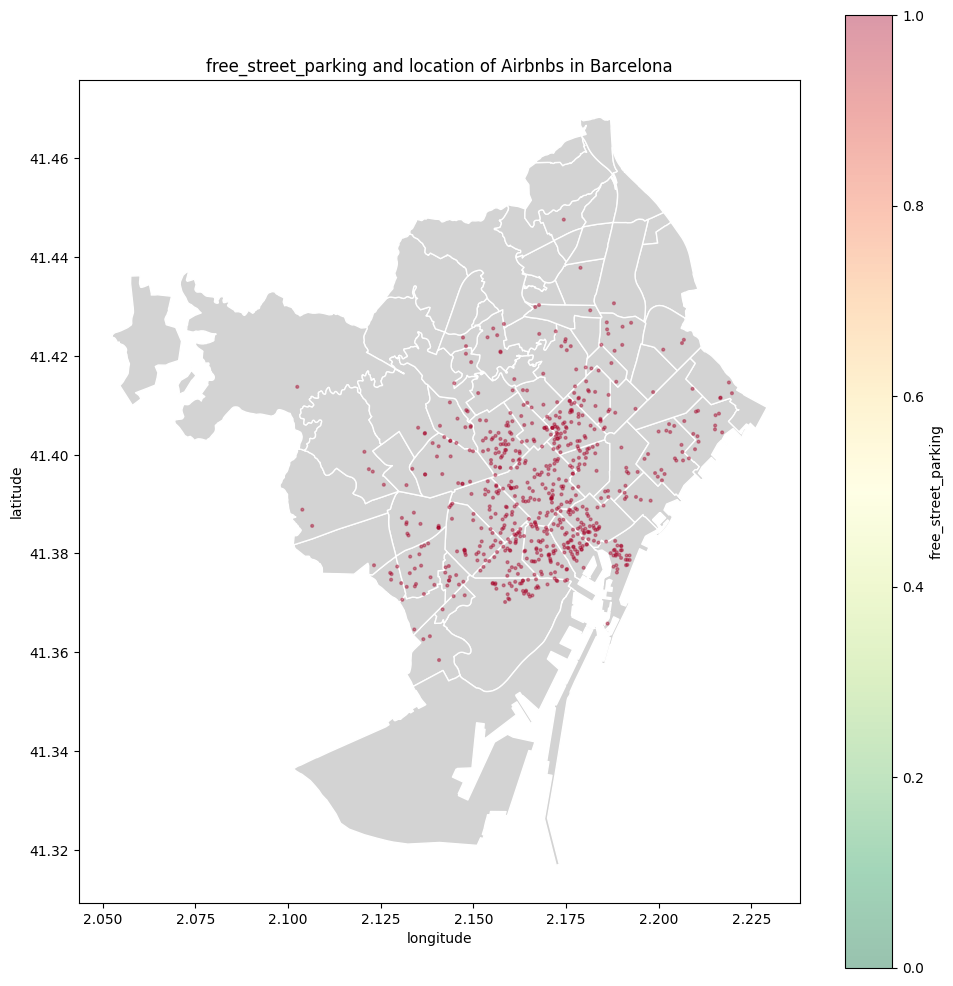

In [10]:
plotData("free_street_parking",1)


## Format data in cells

In [11]:
#license only relevant if true or false
listing_data['license'] = listing_data['license'].apply(lambda x: 1 if pd.notna(x) else 0)
#TODO 1 0 encoding for all t f classes

#latin1 to closest ascii character
def to_ascii(text):
    if not isinstance(text, str):
        return text  
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')

column_names = listing_data.columns.tolist()
for column in column_names:
    if column in ["host_picture_url", "picture_url"]: #Dont mess with links
        listing_data[column] = listing_data[column].apply(to_ascii)

column_names = review_data.columns.tolist()
for column in column_names:
    review_data[column] = review_data[column].apply(to_ascii)

print(listing_data.head())
print(review_data.head())

      id                                               name       host_name  \
0  18674    Huge flat for 8 people close to Sagrada Familia   Mireia  Maria   
1  23197  Forum CCIB DeLuxe, Spacious, Large Balcony, relax  Etain (Marnie)   
2  32711                  Sagrada Familia area - CÃ²rsega 1            Nick   
3  34241   Stylish Top Floor Apartment - Ramblas Plaza Real          Andres   
4  34981               VIDRE HOME PLAZA REAL on LAS RAMBLAS          Andres   

  neighbourhood_group                        neighbourhood   latitude  \
0            Eixample                  la Sagrada FamÃ­lia  41.405560   
1         Sant MartÃ­               el BesÃ²s i el Maresme  41.412432   
2             GrÃ cia  el Camp d'en Grassot i GrÃ cia Nova  41.405660   
3        Ciutat Vella                      el Barri GÃ²tic  41.380620   
4        Ciutat Vella                      el Barri GÃ²tic  41.379780   

   longitude        room_type  price  minimum_nights  ...  mini_fridge  \
0    2.17262

In [12]:

#license only relevant if true or false
listing_data['license'] = listing_data['license'].apply(lambda x: 1 if pd.notna(x) else 0)
#for column in listing_data.columns.tolist():
#print(listing_data.columns.tolist())   
print(len(listing_data.columns.tolist()))


169


In [13]:
#extracting categories
category_dict = {}
category_data_columns = ['neighbourhood_group', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'room_type', 'host_location', 'host_neighbourhood', 'host_response_time', 'property_type']
for column in category_data_columns:
    column_categories = []
    for x in listing_data[column]:
        if x not in column_categories:
            column_categories.append(x)
    category_dict[column] = column_categories
category_dict

#license only relevant if true or false
listing_data['license'] = listing_data['license'].apply(lambda x: 1 if pd.notna(x) else 0)
#print(listing_data.columns.tolist())   

## t, f to 0, 1
for category in listing_data.columns.tolist():
    if 't' in listing_data[category].tolist() and 'f' in listing_data[category].tolist():
        print(category)
        listing_data[category] = listing_data[category].apply(lambda x: 1 if x == 't' else 0)
        print(listing_data[category].head())

#print(category_dict)

# One-hot encoding for categorical columns
for column in category_data_columns:
    # Get unique categories for this column
    unique_categories = category_dict[column]


    
    # Create dummy variables for each category
    for category in unique_categories:
        cat_name = str(category).replace(' ', '_').replace(',','').lower()
        listing_data[f'{column}_{cat_name}'] = (listing_data[column] == category).astype(int)
    
    # Drop the original column (optional)
    listing_data.drop(column, axis=1, inplace=True)

#handle host verifications
verificat_list = []
for listing in listing_data["host_verifications"]:
    listing = str(listing).replace('[]"', '').replace("[", "").replace("]", "").replace('"', '')
    listing = listing.split(',')
    for x in listing:
        x = x.strip().lower()
        if x not in verificat_list:
            verificat_list.append(x)

def encode_verifications(verifications_str):
    verifications = str(verifications_str).replace('[]"', '').replace("[", "").replace("]", "").replace('"', '')
    verifications_list = [v.strip().lower() for v in verifications.split(',')]
    row = {}
    categories = []
    
    for category in verificat_list:
        row["verificaions_" + category] = int(any(category in a for a in verifications_list))
    return row
    

encoded_df = listing_data["host_verifications"].apply(encode_verifications).apply(pd.Series)
encoded_df.columns = [col.replace(" ", "_") for col in encoded_df.columns]
listing_data = pd.concat([listing_data, encoded_df], axis=1)
listing_data = listing_data.drop(columns='host_verifications')


host_is_superhost
0    0
1    0
2    0
3    0
4    0
Name: host_is_superhost, dtype: int64
host_has_profile_pic
0    1
1    1
2    1
3    1
4    1
Name: host_has_profile_pic, dtype: int64
host_identity_verified
0    1
1    1
2    1
3    1
4    1
Name: host_identity_verified, dtype: int64
has_availability
0    1
1    1
2    1
3    1
4    1
Name: has_availability, dtype: int64
instant_bookable
0    1
1    0
2    0
3    0
4    0
Name: instant_bookable, dtype: int64


0    1
1    1
2    1
3    0
4    1
Name: property_type_entire_rental_unit, dtype: int64


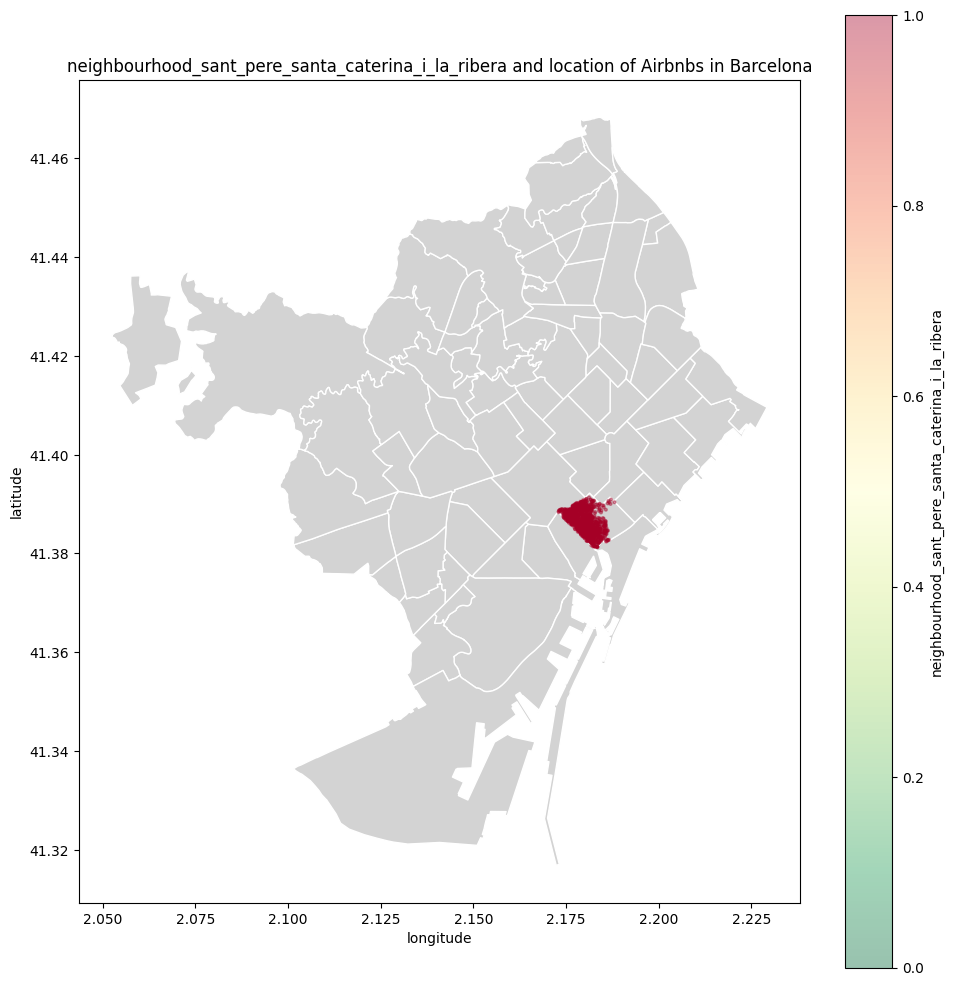

In [14]:
print(listing_data['property_type_entire_rental_unit'].head())
plotData("neighbourhood_sant_pere_santa_caterina_i_la_ribera",1)

In [15]:
print(listing_data["picture_url"][100])
print(listing_data["host_picture_url"][0])

https://a0.muscache.com/pictures/hosting/Hosting-U3RheVN1cHBseUxpc3Rpbmc6MTk2MDIx/original/1388c2ff-321b-4191-a8f5-76e3781e8a48.jpeg
https://a0.muscache.com/im/pictures/user/User-71615/original/ef6beed8-ebe5-4ab3-9798-11fd00a07a6f.jpeg?aki_policy=profile_x_medium


In [16]:
#downloading the images
#DO NOT RUN AGAIN - THE IMAGES ARE ALREADY DOWNLOADED AND STORED IN /kaggle/working
os.makedirs('/kaggle/working/picture_url_128x128', exist_ok=True)
os.makedirs('/kaggle/working/host_picture_url_128x128', exist_ok=True)

def download_and_resize(url, filename, directory, size=(128, 128)):
    try:
        # Download image
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        
        # Open image
        img = Image.open(BytesIO(response.content))
        
        # Handle alpha channel if exists
        if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
            background = Image.new('RGB', img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[-1])  # Use alpha channel as mask
            img = background
        
        # Convert to RGB if not already (for CMYK, L, etc.)
        elif img.mode != 'RGB':
            img = img.convert('RGB')
            
        # Resize and save
        img = img.resize(size, Image.Resampling.LANCZOS)
        img.save(f'/kaggle/working/{directory}/{filename}.jpg', 'JPEG', quality=85)
        return True
        
    except Exception as e:
        print(f"Failed to process {url}: {str(e)}")
        return False

# Process all images (adjust batch size as needed)
for i, row in listing_data.iterrows():
    download_and_resize(row['picture_url'], f"image_{row['id']}", "picture_url_128x128")
    download_and_resize(row['host_picture_url'], f"image_{row['id']}", "host_picture_url_128x128")

Failed to process https://a0.muscache.com/im/users/1642180/profile_pic/1355764406/original.jpg?aki_policy=profile_x_medium: bad transparency mask
Failed to process https://a0.muscache.com/pictures/23709174/98ad966a_original.jpg: 403 Client Error: Forbidden for url: https://a0.muscache.com/pictures/23709174/98ad966a_original.jpg
Failed to process https://a0.muscache.com/pictures/12143652/3ac89dc7_original.jpg: 403 Client Error: Forbidden for url: https://a0.muscache.com/pictures/12143652/3ac89dc7_original.jpg
Failed to process https://a0.muscache.com/pictures/65006964/b30a4603_original.jpg: 403 Client Error: Forbidden for url: https://a0.muscache.com/pictures/65006964/b30a4603_original.jpg
Failed to process https://a0.muscache.com/pictures/16388716/0b2a828f_original.jpg: 403 Client Error: Forbidden for url: https://a0.muscache.com/pictures/16388716/0b2a828f_original.jpg
Failed to process https://a0.muscache.com/pictures/25583691/b36756e6_original.jpg: 403 Client Error: Forbidden for url

In [17]:
#zip images for download

def zip_images_in_batches(src_folder, batch_size=10000):
    images = sorted(os.listdir(src_folder))
    batch_num = 0
    for i in range(0, len(images), batch_size):
        zip_name = f"/kaggle/working/images_batch_{batch_num}.zip"
        with zipfile.ZipFile(zip_name, 'w') as zipf:
            for img in images[i:i+batch_size]:
                zipf.write(os.path.join(src_folder, img), arcname=img)
        print(f"Created: {zip_name}")
        batch_num += 1

zip_images_in_batches('/kaggle/working/host_picture_url_128x128')
zip_images_in_batches('/kaggle/working/picture_url_128x128')

Created: /kaggle/working/images_batch_0.zip
Created: /kaggle/working/images_batch_1.zip
Created: /kaggle/working/images_batch_0.zip
Created: /kaggle/working/images_batch_1.zip


In [18]:
#Add Image links
#f'/kaggle/working/{directory}/{filename}.jpg

In [19]:
#TODO - date to numerical !!!
#listing_data
#Text to TF-IDF encoding
for col in listing_data.columns.tolist():
    print(col + " : " + str(listing_data[col][0]))

text_columns = ["name", "description", "neighbourhood_overview", "host_about", ""]


id : 18674
name : Huge flat for 8 people close to Sagrada Familia
host_name : Mireia  Maria
latitude : 41.40556
longitude : 2.17262
price : 179.0
minimum_nights : 1
number_of_reviews : 45
last_review : 2024-09-16
reviews_per_month : 0.31
calculated_host_listings_count : 29
availability_365 : 147
number_of_reviews_ltm : 5
license : 1
description : 110m2 apartment to rent in Barcelona. Located in the Eixample district, near the Sagrada Familia. It has a small balcony where you can see the temple of Gaudi. Capacity for 8 people. <br /><br />Licence number: HUTB-002062
neighborhood_overview : Apartment in Barcelona located in the heart of Eixample district, within only 150 m form the great Sagrada Familia and really near of GaudÃ­ Avenue and the famous Sant Pau Hospital . <br />All kind of services in surroundings (shops, supermarkets, restaurants, bars).
picture_url : https://a0.muscache.com/pictures/13031453/413cdbfc_original.jpg
host_since : 2010-01-19
host_about : We are Mireia (47) & 

In [20]:
#TODO - Export Dataframes

# Train the model
### Linear Regression